In [1]:
import pandas as pd
import numpy as np
import requests
import json
import math

# 1. User Input and Data Collection

In [50]:
def tickerFunc(): #search for ticker, obtain results
    global ticker
    ticker = str(input("Enter a ticker (short character string): "))
    
    ticker = ticker.upper()

    confirm = 'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords='+ticker+'&apikey=DN1PUQALCFSLB5MQ' # call search endpoint utility, REPLACE WITH OWN KEY OR WHATEVER
    confirmResp = requests.get(confirm)

    confirmData = confirmResp.json()

    confirmFrame = pd.DataFrame(confirmData["bestMatches"]) #constructing a DataFrame using the JSON
    confirmFrame = confirmFrame
    
    global tickercomp
    
    for i in specialChars:
        tickercomp = ticker.replace(i,"")
        
    global tickerlist
    tickerlist = []
    for i in confirmFrame["1. symbol"]:
        for c in specialChars:
            i = i.replace(c,"") # writing clean search results to list for matching to ticker input, for any foreign market
        tickerlist.append(i)

In [51]:
specialChars = ["!","@","^","=","/",",","."," "]

tickerFunc()

while True:
    if tickercomp not in tickerlist:
        print("This ticker does not appear in the database")
        tickerFunc()
    else:
        print("This ticker appears in the database")
        break

Enter a ticker (short character string): hd










This ticker appears in the database


In [52]:
#You can build the API call as one url or you can use variables for the different query parameters
asset = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+ticker+'&outputsize=full&apikey=DN1PUQALCFSLB5MQ' #REPLACE WITH OWN KEY
spx = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey=DN1PUQALCFSLB5MQ' #REPLACE WITH OWN KEY
# SPY needs to be used because alphavantage does not support indices

assetResp = requests.get(asset)
spxResp = requests.get(spx)
assetResp, spxResp #to verify that we made successful calls

(<Response [200]>, <Response [200]>)

In [55]:
assetData = assetResp.json()
#assetData #we can verify the data by outputting the JSON

In [58]:
spxData = spxResp.json()
#spxData #we can verify the data by outputting the JSON

In [59]:
assetFrame = pd.DataFrame(assetData["Time Series (Daily)"]) #constructing a DataFrame using the JSON
assetFrame = assetFrame.T
assetDateRange = pd.DataFrame(assetFrame.loc['2017-12-31':'2017-01-01']) #constructing a new DataFrame with a specific date range 
assetDateRange.iloc[::-1].head()

,1. open,2. high,3. low,4. close,5. volume
2017-01-03,135.1000,135.5100,133.5890,134.3100,5300410
2017-01-04,134.3400,135.9400,134.2100,135.5000,4055284
2017-01-05,134.9800,135.4600,133.7801,133.9000,3821073
2017-01-06,133.9700,134.3300,133.0500,133.5300,3827482
2017-01-09,133.2200,134.7600,133.1400,134.3100,4310227


In [60]:
spxFrame = pd.DataFrame(spxData["Time Series (Daily)"]) #constructing a DataFrame using the JSON
spxFrame = spxFrame.T
spxDateRange = pd.DataFrame(spxFrame.loc['2017-12-31':'2017-01-01']) #constructing a new DataFrame with a specific date range 
spxDateRange.iloc[::-1].head()

,1. open,2. high,3. low,4. close,5. volume
2017-01-03,225.0400,225.8300,223.8800,225.2400,91366500
2017-01-04,225.6200,226.7500,225.6100,226.5800,78744400
2017-01-05,226.2700,226.5800,225.4800,226.4000,78379000
2017-01-06,226.5300,227.7500,225.9000,227.2100,71559900
2017-01-09,226.9100,227.0700,226.4200,226.4600,46939700


In [556]:
assetReturns = assetDateRange['4. close'].astype(float)#.pct_change() #astype is used here since all the data returned are strings



2017-12-29    189.53
2017-12-28    189.78
2017-12-27    190.19
2017-12-26    190.36
2017-12-22    188.13
Name: 4. close, dtype: float64


In [557]:
spxReturns = spxDateRange['4. close'].astype(float)#.pct_change()



2017-12-29    266.86
2017-12-28    267.87
2017-12-27    267.32
2017-12-26    267.19
2017-12-22    267.51
Name: 4. close, dtype: float64


In [562]:
combined = pd.DataFrame([assetReturns,spxReturns],index=[ticker+' Close', 'SPY Close'])
combined = combined.T[::-1]
print(combined.head())
print("\nTotal Rows: ",len(combined.index))


            HD Close  SPY Close
2017-01-03    134.31     225.24
2017-01-04    135.50     226.58
2017-01-05    133.90     226.40
2017-01-06    133.53     227.21
2017-01-09    134.31     226.46

Total Rows:  251


# 2. Percentage Changes in Daily Closing Price

In [560]:
combinedPC = combined.pct_change().dropna()
combinedPC = combinedPC.rename(columns = {ticker+" Close":ticker+" Percent Change (%)", "SPY Close":"SPY Percent Change (%)"})


for i in combinedPC.index:
    combinedPC.loc[i] = round(combinedPC.loc[i] * 100,3) # Display percent changes in percentage form
    
print(combinedPC.head())
print("\nTotal Rows: ",len(combinedPC.index))

            HD Percent Change (%)  SPY Percent Change (%)
2017-01-04                  0.886                   0.595
2017-01-05                 -1.181                  -0.079
2017-01-06                 -0.276                   0.358
2017-01-09                  0.584                  -0.330
2017-01-10                  1.333                   0.000

Total Rows:  250


In [537]:
t = 0
combinedPCReset = combinedPC.reset_index()

datenums = []
datelist = []

datenums.append(combinedPCReset.index[0])
datelist.append(combinedPCReset["index"][0][5:7])

for i in combinedPCReset.index:    #Obtain first available day of the month, use the index of the row where it appears as the labels for x-axis bar graph
    t+=1
    if combinedPCReset["index"][t-1][5:7] in datelist[-1]:
        continue
    datenums.append(combinedPCReset.index[t-1])
    datelist.append(combinedPCReset["index"][t-1][5:7])

Axes(0.125,0.11;0.775x0.77)


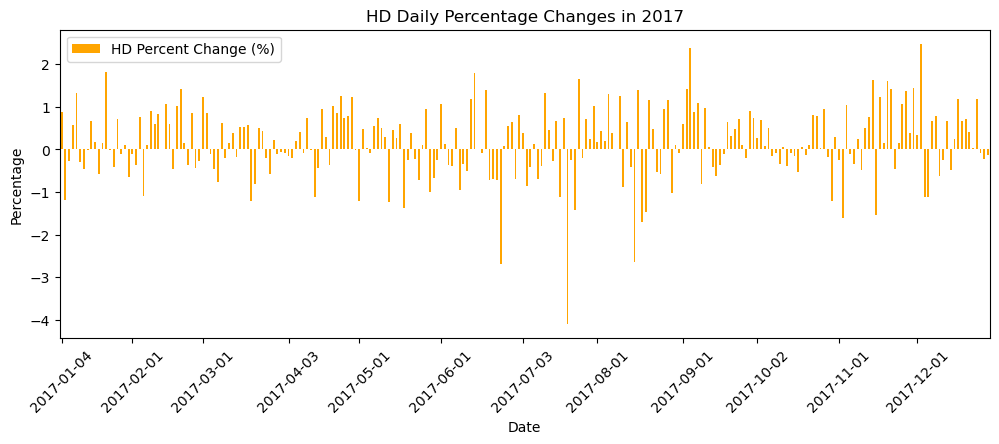

In [565]:
combinedPCbar = combinedPC.plot.bar(y = ticker+" Percent Change (%)", xlabel = "Date", ylabel = "Percentage", figsize=(12,4), rot = 45, color="orange")
combinedPCbar.set(xticks = datenums, title = ticker+" Daily Percentage Changes in 2017")
print(combinedPCbar)

In [566]:
del combinedPCReset
del datelist
del combinedPCbar

In [567]:
assetValues = []
spxValues = []

In [568]:
assetValues.clear()
spxValues.clear()

#--------------------------------------------------
#--------------------------------------------------
# MEANS
    # Asset
meanSum = 0

for i in combined[ticker+" Close"]:
    meanSum += i
    
assetMean = round(meanSum / len(combined.index),3)
assetValues.append(assetMean)

    # SPY
meanSum = 0

for i in combined["SPY Close"]:
    meanSum += i
    
spyMean = round(meanSum / len(combined.index),3)
spxValues.append(spyMean)


#--------------------------------------------------
#--------------------------------------------------
# STANDARD DEVIATIONS
    # Asset
stdSum = 0

for i in combined[ticker+" Close"]:
    stdSum = (i - assetMean) ** 2
    
assetStd = round(math.sqrt(stdSum / len(combined.index)),3)
assetValues.append(assetStd)

    # SPY
stdSum = 0

for i in combined["SPY Close"]:
    stdSum = (i - assetMean) ** 2
    
spxStd = round(math.sqrt(stdSum / len(combined.index)),3)
spxValues.append(spxStd)


#--------------------------------------------------
#--------------------------------------------------
# VARIANCES
    # Asset
assetVar = round(assetStd ** 2,3)
assetValues.append(assetVar)

    # SPY
spxVar = round(spxStd ** 2,3)
spxValues.append(spxVar)


#--------------------------------------------------
#--------------------------------------------------
# MINS
    # Asset
min = combined[ticker+" Close"][0]

for i in combined[ticker+" Close"]:
    if i < min:
        min = i
        
assetMin = round(min,3)
assetValues.append(assetMin)

    # Asset
min = combined["SPY Close"][0]

for i in combined["SPY Close"]:
    if i < min:
        min = i
        
spxMin = round(min,3)
spxValues.append(spxMin)


#--------------------------------------------------
#--------------------------------------------------
# MAXS
    # Asset
max = combined[ticker+" Close"][0]

for i in combined[ticker+" Close"]:
    if i > max:
        max = i
        
assetMax = round(max,3)
assetValues.append(assetMax)

    # Asset
max = combined["SPY Close"][0]

for i in combined["SPY Close"]:
    if i > max:
        max = i
        
spxMax = round(max,3)
spxValues.append(spxMax)

combinedDict = {ticker+" Close":assetValues,"SPY Close":spxValues}

In [569]:

combinedStats = pd.DataFrame(combinedDict, index = ["Mean","Standard Deviation","Variance","Min","Max"])
combinedStats

,HD Close,SPY Close
Mean,155.343,244.696
Standard Deviation,2.158,7.039
Variance,4.657,49.548
Min,133.530,225.240
Max,190.360,268.200
